In [1]:
from datasets import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split

TRAIN_DATA_PATH = '/Users/nikolaj/Desktop/datathon/review_chunks/score_training.csv'
use_cols = ["text", "service_score"]

df = pd.read_csv(TRAIN_DATA_PATH, usecols=use_cols)
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42)


train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
eval_dataset = Dataset.from_pandas(eval_df.reset_index(drop=True))
print(df.head())

/Users/nikolaj/anaconda3/envs/datathon/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                                                text  service_score
0  While I was sad to see Bibo close at this loca...           0.50
1  Friendly baristas and great coffee. Since thei...           0.80
2  Love their coffee and vibe. The breakfast food...           0.60
3  It's like everything you try is your new favor...           0.90
4  This is probably one of my favorite boba place...           0.95


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

train_tokenized = train_dataset.map(
    lambda example: tokenizer(
        str(example["text"]),
        truncation=True,
        padding="max_length",
        max_length=128
    )
)
eval_tokenized = eval_dataset.map(
    lambda example: tokenizer(
        str(example["text"]),
        truncation=True,
        padding="max_length",
        max_length=128
    )
)

train_tokenized = train_tokenized.rename_column("service_score", "labels")
eval_tokenized = eval_tokenized.rename_column("service_score", "labels")
train_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
eval_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Map: 100%|██████████| 60/60 [00:00<00:00, 1745.40 examples/s]


In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import accelerate
from torch import nn

class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.MSELoss()
        loss = loss_fct(logits.squeeze(), labels.squeeze())
        return (loss, outputs) if return_outputs else loss

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels=1,  
    problem_type="regression"  
)

training_args = TrainingArguments(
    output_dir="./service_model",
    per_device_train_batch_size=16,
    num_train_epochs=3,
    logging_dir='./logs',
    save_steps=500,
)

def add_labels(example):
    example['labels'] = example['service_score']
    return example


trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=eval_tokenized,
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


TrainOutput(global_step=45, training_loss=0.046870448854234484, metrics={'train_runtime': 52.3272, 'train_samples_per_second': 13.76, 'train_steps_per_second': 0.86, 'total_flos': 23843706531840.0, 'train_loss': 0.046870448854234484, 'epoch': 3.0})

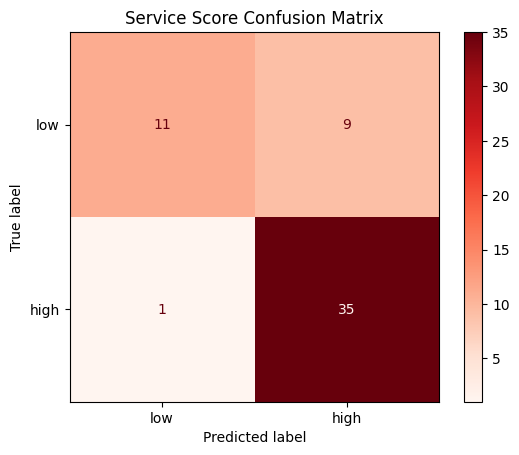

In [ ]:
predictions = trainer.predict(eval_tokenized)

pred_scores = predictions.predictions.squeeze()  
true_scores = predictions.label_ids.squeeze()

bins = [0.0, 0.5, 1.0]
labels = ['low', 'high']

pred_bins = pd.cut(pred_scores, bins=bins, labels=labels, include_lowest=True).astype(str)
true_bins = pd.cut(true_scores, bins=bins, labels=labels, include_lowest=True).astype(str)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_bins, pred_bins, labels=labels)
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Reds")

plt.title("Service Score Confusion Matrix") 
plt.show()



In [15]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_bins, pred_bins)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7667


In [7]:
from transformers import pipeline

classifier_service = pipeline("text-classification", model=model, tokenizer=tokenizer)

review = "As a whole, customer service in IV sucks. But, my caramel latte tonight was very very good. I owe it to the barista. I guess my last experience was bad due to the employee. But this guy made my latte with a beautiful heart and thankfully it made fall in love with their lattes. Now I won't have to to to French Press as often ;)"
classifier_service(review)

Device set to use mps:0


[{'label': 'LABEL_0', 'score': 0.4845851957798004}]

In [ ]:
import joblib

joblib.dump(classifier_service, "classifier_service.pkl")

['classifier_service.pkl']